In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
import numpy as np
import seaborn as sns
import requests
import zipfile
import io

In [2]:
# Celda para mostrar todas las columnas y todo el texto en ellas (con Pandas)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

Descargar archivos

In [3]:
url = 'https://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip'
url_diccionarios = 'https://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/diccionario_datos_covid19.zip'

In [85]:
# Esta celda descarga archivos con un peso aprox. de 1GB.
# Si no se desea descargar localmente los archivos no ejecute esta celda

# Descargar y descomprimir la base de datos
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

# Descargar y descomprimir diccionarios
r2 = requests.get(url_diccionarios)
z2 = zipfile.ZipFile(io.BytesIO(r2.content))
z2.extractall()

In [4]:
# Se descarga, descomprime y lee al tiempo (no es necesario descargar localmente los archivos)
data_original = pd.read_csv(url)

C:\Users\ricar\AppData\Local\Temp\ipykernel_16012\4247310933.py:2: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  data_original = pd.read_csv(url)


In [5]:
# Información general del dataset
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7171935 entries, 0 to 7171934
Data columns (total 40 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   FECHA_ACTUALIZACION    object
 1   ID_REGISTRO            object
 2   ORIGEN                 int64 
 3   SECTOR                 int64 
 4   ENTIDAD_UM             int64 
 5   SEXO                   int64 
 6   ENTIDAD_NAC            int64 
 7   ENTIDAD_RES            int64 
 8   MUNICIPIO_RES          int64 
 9   TIPO_PACIENTE          int64 
 10  FECHA_INGRESO          object
 11  FECHA_SINTOMAS         object
 12  FECHA_DEF              object
 13  INTUBADO               int64 
 14  NEUMONIA               int64 
 15  EDAD                   int64 
 16  NACIONALIDAD           int64 
 17  EMBARAZO               int64 
 18  HABLA_LENGUA_INDIG     int64 
 19  INDIGENA               int64 
 20  DIABETES               int64 
 21  EPOC                   int64 
 22  ASMA                   int64 
 23  INMUSUP

In [6]:
# Convertir columnas con fecha a tipo datetime
for col in data_original.columns:
    if col[:5] == 'FECHA':
        try:
            # los tipos de fecha '9999-99-99' los convierte en un tipo Nan
            data_original[col] = pd.to_datetime(data_original[col], format="%Y/%m/%d", errors='coerce')
            print(f'Columna {col} convertida a tipo datetime')
        except Exception as e:
            print(e)

Columna FECHA_ACTUALIZACION convertida a tipo datetime
Columna FECHA_INGRESO convertida a tipo datetime
Columna FECHA_SINTOMAS convertida a tipo datetime
Columna FECHA_DEF convertida a tipo datetime


In [7]:
# Inspeccionamos la primer y ultima fecha del dataset
print(f"El dataset inicia el {data_original['FECHA_INGRESO'].min()}")
print(f"El dataset termina el {data_original['FECHA_INGRESO'].max()}")

El dataset inicia el 2022-01-01 00:00:00
El dataset termina el 2023-04-18 00:00:00


Solo se toman en cuenta pacientes que fueron ingresados a hospitalización ('TIPO_PACIENTE' = 2) y a los cuales se les confirmó que en realidad tenían COVID ('CLASIFICACION_FINAL' 1, 2 o 3) entonces se crea el siguient df:

In [8]:
df_hosp_covid = data_original[(data_original['TIPO_PACIENTE'] == 2) & (data_original['CLASIFICACION_FINAL'].isin([1,2,3]))]

In [9]:
df_hosp_covid.shape

(103452, 40)

Se sabe que si la persona tiene fecha de deceso entonces murió por COVID:

In [10]:
# Crear nueva columna indicando si el paciente murió.
# Si tiene fecha de deceso entonces 1, si fecha de deceso es Nan entonces 0
df_hosp_covid['MUERTE'] = pd.notna(df_hosp_covid['FECHA_DEF']).astype(int)

C:\Users\ricar\AppData\Local\Temp\ipykernel_16012\3571238989.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hosp_covid['MUERTE'] = pd.notna(df_hosp_covid['FECHA_DEF']).astype(int)


In [11]:
df_hosp_covid.head(10)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,MUERTE
19,2023-04-18,100caf,1,6,17,1,21,17,1,2,2022-08-19,2022-08-14,NaT,2,1,84,1,2,2,2,1,2,2,2,1,2,1,2,2,2,2,2,97,1,2,1,99,México,97,2,0
52,2023-04-18,0741e4,2,6,9,2,9,9,16,2,2022-02-20,2022-02-13,2022-02-21,2,1,54,1,97,2,2,2,2,2,2,1,2,2,2,1,2,2,1,4,2,97,2,99,México,97,2,1
62,2023-04-18,1d5334,1,12,12,1,12,12,29,2,2022-01-12,2022-01-09,NaT,2,2,28,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,97,1,1,3,99,México,97,2,0
85,2023-04-18,07977b,2,12,14,2,14,14,9,2,2022-01-06,2022-01-02,NaT,2,2,30,1,97,2,2,2,2,2,2,2,2,2,2,2,2,1,2,97,1,1,3,99,México,97,2,0
387,2023-04-18,b26367,2,12,3,2,3,3,3,2,2022-01-25,2022-01-24,NaT,2,2,69,1,97,2,2,2,1,2,2,1,2,1,2,2,1,99,2,97,1,1,3,99,México,97,2,0
563,2023-04-18,788695,2,11,25,1,25,25,1,2,2022-01-08,2022-01-05,NaT,2,2,40,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,97,3,99,México,97,2,0
677,2023-04-18,79a031,2,12,9,1,9,9,15,2,2022-03-18,2022-03-18,NaT,2,2,3,1,2,2,1,2,2,2,2,2,2,2,2,2,2,2,1,4,1,2,1,99,México,97,2,0
874,2023-04-18,8f1b25,1,12,12,1,12,12,55,2,2022-01-29,2022-01-25,NaT,2,1,32,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,1,1,3,99,México,97,2,0
883,2023-04-18,da42fe,1,6,8,2,8,8,19,2,2022-01-06,2022-01-02,2022-01-12,2,2,61,1,97,2,2,2,1,2,2,2,2,1,1,2,2,2,1,1,2,97,3,99,México,97,1,1
914,2023-04-18,9b5259,1,4,15,1,15,15,25,2,2022-01-01,2022-01-01,NaT,2,2,4,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,97,1,1,3,99,México,97,2,0


Ajustamos la fecha de ingreso como indice del df para manejarlo de una mejor manera 

In [12]:
df_hosp_covid.set_index('FECHA_INGRESO', inplace=True)

Se crea una columna con el numero de la semana correspondiente

In [13]:
df_hosp_covid['NO_SEMANA'] = 0
df_hosp_covid['NO_SEMANA'] = df_hosp_covid.index.isocalendar().week

C:\Users\ricar\AppData\Local\Temp\ipykernel_16012\45143856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hosp_covid['NO_SEMANA'] = 0
C:\Users\ricar\AppData\Local\Temp\ipykernel_16012\45143856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hosp_covid['NO_SEMANA'] = df_hosp_covid.index.isocalendar().week


In [14]:
# Inspeccionando el df aparece una semana 52 en el 2023 (sin embargo el ultimo mes de 2023 es abril)
df_hosp_covid.loc['2023']['NO_SEMANA'].unique()

<IntegerArray>
[9, 1, 2, 4, 52, 3, 5, 7, 8, 6, 10, 13, 11, 12, 14, 15, 16]
Length: 17, dtype: UInt32

In [15]:
# Debido a la configuración ISO 8601 (que maneja Pandas en isocalendar().week) los primeros dias del 2023 se consideran como la ultima semana del 2022.
# Lo mismo ocurre con el 2022.
df_hosp_covid[(df_hosp_covid['NO_SEMANA'] == 52) & (df_hosp_covid.index.year == 2023)]

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,MUERTE,NO_SEMANA
FECHA_INGRESO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-01,2023-04-18,g2f7f86,2,4,9,2,15,15,31,2,2022-12-31,NaT,2,2,62,1,97,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,3,99,México,97,2,0,52
2023-01-01,2023-04-18,g315708,2,12,9,2,20,9,11,2,2022-12-30,NaT,2,2,70,1,97,2,2,2,2,2,2,1,2,2,2,2,2,2,2,97,1,1,3,99,México,97,2,0,52
2023-01-01,2023-04-18,g23826b,1,12,13,1,13,13,8,2,2022-12-29,NaT,2,2,25,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,97,1,1,3,99,México,97,2,0,52
2023-01-01,2023-04-18,g33af5a,1,4,9,2,14,9,10,2,2022-12-30,NaT,2,1,78,1,97,2,2,2,1,2,2,1,2,2,2,2,2,2,1,1,1,2,3,99,México,97,2,0,52
2023-01-01,2023-04-18,g34942f,1,4,9,1,9,9,14,2,2022-12-21,2023-01-07,2,1,81,1,2,2,2,2,2,2,2,1,2,1,2,2,2,2,2,97,1,1,3,99,México,97,2,1,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01,2023-04-18,g441717,2,6,9,2,9,9,12,2,2022-12-29,NaT,2,2,65,1,97,99,99,2,2,2,2,2,2,2,2,2,2,2,2,97,1,1,3,99,México,97,2,0,52
2023-01-01,2023-04-18,g326fda,1,3,15,2,15,15,106,2,2023-01-01,NaT,2,2,1,1,97,2,2,2,2,2,2,2,2,2,2,2,2,2,1,4,2,97,1,99,México,97,2,0,52
2023-01-01,2023-04-18,g42fc1b,2,9,9,2,9,9,5,2,2022-12-25,NaT,1,1,10,1,97,99,99,2,2,2,2,2,2,2,2,2,2,2,1,1,2,97,3,99,México,97,1,0,52


Se opta por solucionarlo asi: si el mes es Enero y el numero de la semana aparece como 52, entonces el numero de la semana se reemplaza con 1

In [16]:
df_hosp_covid.loc[(df_hosp_covid.index.month == 1) & (df_hosp_covid['NO_SEMANA'] == 52), 'NO_SEMANA'] = 1

In [17]:
# Verificamos los valores unicos de 2022 en NO_SEMANA
df_hosp_covid.loc['2022']['NO_SEMANA'].unique()

<IntegerArray>
[33,  7,  2,  1,  4, 11,  3,  6,  5,  9, 34,  8, 10, 14, 49, 12, 13, 15, 16,
 17, 18, 19, 20, 21, 22, 24, 23, 25, 26, 27, 29, 28, 30, 32, 31, 35, 36, 37,
 38, 39, 40, 41, 43, 42, 46, 44, 45, 47, 48, 52, 50, 51]
Length: 52, dtype: UInt32

In [18]:
# Verificamos los valores unicos de 2023 en NO_SEMANA
df_hosp_covid.loc['2023']['NO_SEMANA'].unique()

<IntegerArray>
[9, 1, 2, 4, 3, 5, 7, 8, 6, 10, 13, 11, 12, 14, 15, 16]
Length: 16, dtype: UInt32

Por ultimo se crea una columna YEAR (año) que será de ayuda en la visualización de las gráficas

In [19]:
# Guardar año en nueva columna
df_hosp_covid['YEAR'] = df_hosp_covid.index.year

C:\Users\ricar\AppData\Local\Temp\ipykernel_16012\1335522103.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hosp_covid['YEAR'] = df_hosp_covid.index.year


In [20]:
df_hosp_covid.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,MUERTE,NO_SEMANA,YEAR
FECHA_INGRESO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-08-19,2023-04-18,100caf,1,6,17,1,21,17,1,2,2022-08-14,NaT,2,1,84,1,2,2,2,1,2,2,2,1,2,1,2,2,2,2,2,97,1,2,1,99,México,97,2,0,33,2022
2022-02-20,2023-04-18,0741e4,2,6,9,2,9,9,16,2,2022-02-13,2022-02-21,2,1,54,1,97,2,2,2,2,2,2,1,2,2,2,1,2,2,1,4,2,97,2,99,México,97,2,1,7,2022
2022-01-12,2023-04-18,1d5334,1,12,12,1,12,12,29,2,2022-01-09,NaT,2,2,28,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,97,1,1,3,99,México,97,2,0,2,2022
2022-01-06,2023-04-18,07977b,2,12,14,2,14,14,9,2,2022-01-02,NaT,2,2,30,1,97,2,2,2,2,2,2,2,2,2,2,2,2,1,2,97,1,1,3,99,México,97,2,0,1,2022
2022-01-25,2023-04-18,b26367,2,12,3,2,3,3,3,2,2022-01-24,NaT,2,2,69,1,97,2,2,2,1,2,2,1,2,1,2,2,1,99,2,97,1,1,3,99,México,97,2,0,4,2022


### Dataframe México

In [21]:
df_mexico_1 = df_hosp_covid.copy(deep=True)

In [22]:
# Verificamos total de personas en semana 1 del 2022
df_mexico_1[(df_mexico_1['NO_SEMANA'] == 1) & (df_mexico_1.index.year == 2022)]['NO_SEMANA'].count()

3796

In [23]:
# Verificamos el total de personas muertas en la semana 1 del 2022
df_mexico_1[(df_mexico_1['MUERTE'] == 1) & (df_mexico_1['NO_SEMANA'] == 1) & (df_mexico_1.index.year == 2022)]['NO_SEMANA'].count()

1042

In [24]:
# Verificamos el total de personas que sobrevivieron en la semana 1 del 2022
df_mexico_1[(df_mexico_1['MUERTE'] == 0) & (df_mexico_1['NO_SEMANA'] == 1) & (df_mexico_1.index.year == 2022)]['NO_SEMANA'].count()

2754

Filtramos columnas necesarias

In [25]:
df_mexico_semana = df_mexico_1[['MUERTE', 'NO_SEMANA', 'YEAR']]
df_mexico_semana.head()

,MUERTE,NO_SEMANA,YEAR
FECHA_INGRESO,,,
2022-08-19,0,33,2022
2022-02-20,1,7,2022
2022-01-12,0,2,2022
2022-01-06,0,1,2022
2022-01-25,0,4,2022


La primera fila del siguiente df confirma los totales obtenidos en las celdas anteriores

In [26]:
# Contamos el total de personas y sumamos las que murieron (unos)
df_mexico_semana = df_mexico_semana.groupby(['YEAR', 'NO_SEMANA']).agg(['sum', 'count']).reset_index()
df_mexico_semana.head(65)

YEAR NO_SEMANA MUERTE       
                      sum  count
0   2022         1   1042   3796
1   2022         2   2492   8281
2   2022         3   3816  11088
3   2022         4   4326  11288
4   2022         5   3340   8388
..   ...       ...    ...    ...
60  2023         9     78    670
61  2023        10     86    750
62  2023        11     87    696
63  2023        12     73    633
64  2023        13     49    574

[65 rows x 4 columns]

In [27]:
# 'Aplanar' nombres de columnas multi-index
df_mexico_semana.columns = ["_".join(pair) for pair in df_mexico_semana.columns]
df_mexico_semana.head(10)

,YEAR_,NO_SEMANA_,MUERTE_sum,MUERTE_count
0,2022,1,1042,3796
1,2022,2,2492,8281
2,2022,3,3816,11088
3,2022,4,4326,11288
4,2022,5,3340,8388
5,2022,6,2139,5197
6,2022,7,1206,3278
7,2022,8,650,2006
8,2022,9,390,1240
9,2022,10,233,884


"La letalidad se calcula como el acumulado de pacientes que fueron ingresados respecto a la cantidad de pacientes que al final causaron una lamentable defunción."

$Letalidad[\%] = \dfrac{No.\hspace{2pt} Muertos}{No.\hspace{2pt} Ingresados} \cdot 100$

In [28]:
# Calculamos letalidad en porcentaje
df_mexico_semana['LETALIDAD_SEM'] = (df_mexico_semana['MUERTE_sum'] / df_mexico_semana['MUERTE_count'])*100
df_mexico_semana.head(10)

,YEAR_,NO_SEMANA_,MUERTE_sum,MUERTE_count,LETALIDAD_SEM
0,2022,1,1042,3796,27.449947
1,2022,2,2492,8281,30.092984
2,2022,3,3816,11088,34.415584
3,2022,4,4326,11288,38.323884
4,2022,5,3340,8388,39.818789
5,2022,6,2139,5197,41.158361
6,2022,7,1206,3278,36.790726
7,2022,8,650,2006,32.402792
8,2022,9,390,1240,31.451613
9,2022,10,233,884,26.357466


In [29]:
# Renombramos columnas
df_mexico_semana.rename(
    columns={
        'YEAR_': 'YEAR',
        'NO_SEMANA_': 'NO_SEMANA',
        'MUERTE_sum': 'PERSONAS_MUERTAS',
        'MUERTE_count': 'TOTAL_INGRESADOS',
    },
    inplace=True
)
df_mexico_semana

,YEAR,NO_SEMANA,PERSONAS_MUERTAS,TOTAL_INGRESADOS,LETALIDAD_SEM
0,2022,1,1042,3796,27.449947
1,2022,2,2492,8281,30.092984
2,2022,3,3816,11088,34.415584
3,2022,4,4326,11288,38.323884
4,2022,5,3340,8388,39.818789
...,...,...,...,...,...
63,2023,12,73,633,11.532385
64,2023,13,49,574,8.536585
65,2023,14,35,417,8.393285
66,2023,15,12,322,3.726708


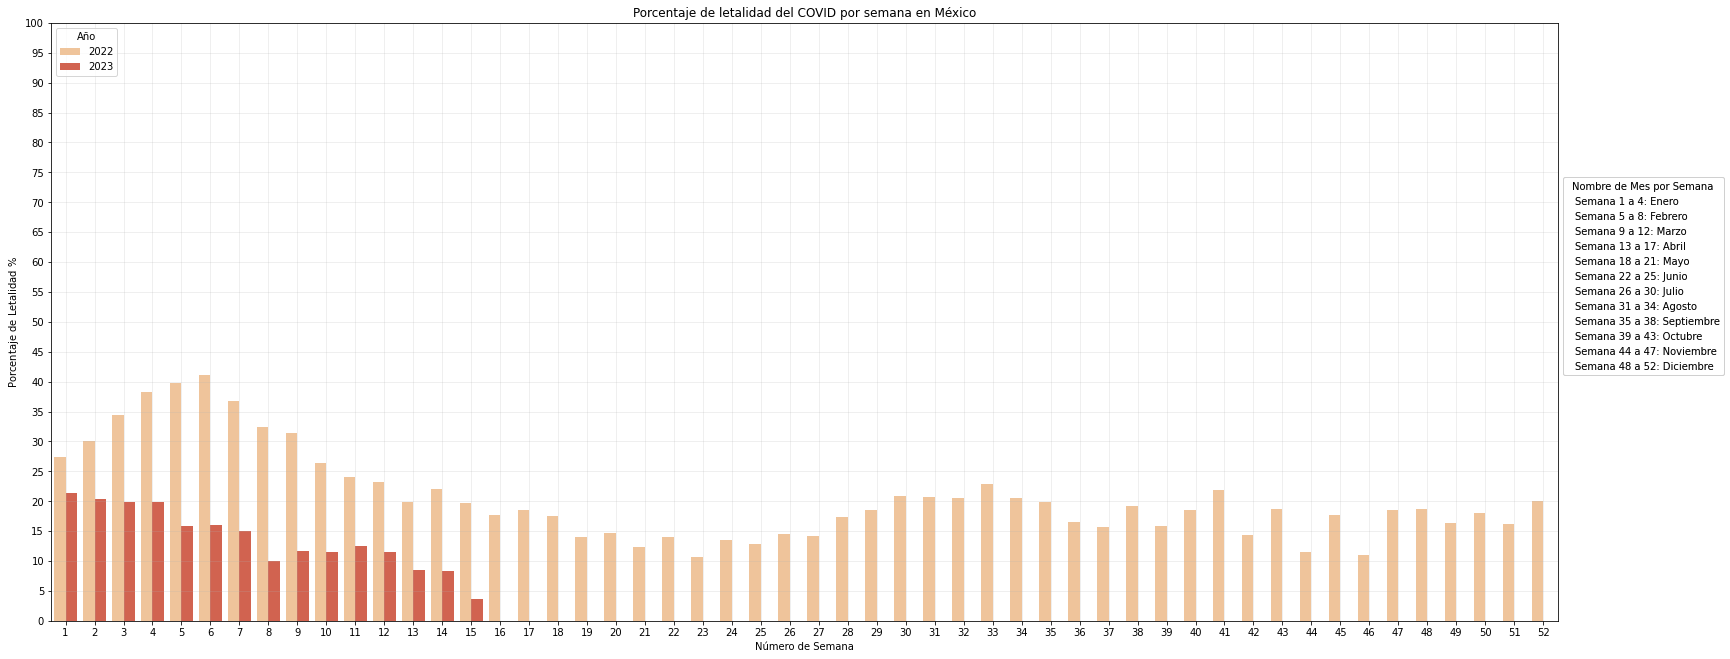

In [153]:
# Gráfica de prueba
plt.figure(figsize=(27,11))
ax = sns.barplot(x=df_mexico_semana['NO_SEMANA'], y=df_mexico_semana['LETALIDAD_SEM'], hue=df_mexico_semana['YEAR'], palette='OrRd')

plt.xlabel('Número de Semana')
plt.ylabel(r'Porcentaje de Letalidad $\%$')
plt.title('Porcentaje de letalidad del COVID por semana en México')
plt.legend(title='Año')
plt.yticks(range(0,101, 5))
plt.xticks(rotation=0)
plt.grid(alpha=0.25)

legend1 = ax.legend(title='Año')
ax.add_artist(legend1)

labels_semana_mes = ['Semana 1 a 4: Enero',
           'Semana 5 a 8: Febrero',
           'Semana 9 a 12: Marzo',
           'Semana 13 a 17: Abril',
           'Semana 18 a 21: Mayo',
           'Semana 22 a 25: Junio',
           'Semana 26 a 30: Julio',
           'Semana 31 a 34: Agosto',
           'Semana 35 a 38: Septiembre',
           'Semana 39 a 43: Octubre',
           'Semana 44 a 47: Noviembre',
           'Semana 48 a 52: Diciembre']

legend2 = ax.legend(labels_semana_mes, title='Nombre de Mes por Semana', loc='upper left', handlelength=0, bbox_to_anchor=(1,0.75))
ax.add_artist(legend2)

plt.show()

### Dataframe Sonora

In [31]:
# Identificador de sonora: 26
df_sonora_1 = df_mexico_1[df_mexico_1['ENTIDAD_RES'] == 26]
df_sonora_1.shape

(2552, 42)

In [32]:
df_sonora_1.head(5)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,MUERTE,NO_SEMANA,YEAR
FECHA_INGRESO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-02,2023-04-18,63f703,1,3,26,1,26,26,30,2,2022-01-01,NaT,2,2,54,1,2,2,2,2,2,2,2,2,1,2,2,2,2,2,1,1,2,97,3,99,México,97,2,0,1,2022
2022-01-02,2023-04-18,e23e01,1,4,26,1,26,26,30,2,2022-01-01,2022-01-08,2,1,94,1,2,2,2,1,2,2,2,1,1,2,2,2,2,2,2,97,1,1,3,99,México,97,2,1,1,2022
2022-01-03,2023-04-18,dacb97,1,12,26,2,26,26,29,2,2022-01-01,NaT,99,2,54,1,97,2,2,2,2,2,2,1,2,2,1,2,2,1,2,97,1,1,3,99,México,97,99,0,1,2022
2022-01-03,2023-04-18,82073d,2,4,26,1,26,26,42,2,2022-01-03,NaT,2,1,72,1,2,2,2,1,2,2,2,2,2,2,1,2,2,2,2,97,1,1,3,99,México,97,2,0,1,2022
2022-01-03,2023-04-18,b61ede,1,4,26,1,25,26,43,2,2022-01-02,NaT,2,1,99,1,2,2,2,1,2,2,2,1,2,2,2,2,2,2,1,1,2,97,3,99,México,97,2,0,1,2022


In [33]:
# Verficiar total personas en semana 1 de 2022
df_sonora_1[(df_sonora_1['NO_SEMANA'] == 1) & (df_sonora_1.index.year == 2022)]['NO_SEMANA'].count()

111

In [34]:
# Verificar personas muertas en la semana 1 de 2022
df_sonora_1[(df_sonora_1['MUERTE'] == 1) & (df_sonora_1['NO_SEMANA'] == 1) & (df_sonora_1.index.year == 2022)]['NO_SEMANA'].count()

33

In [35]:
# Verificar personas que sobreviven en la semana 1 de 2022
df_sonora_1[(df_sonora_1['MUERTE'] == 0) & (df_sonora_1['NO_SEMANA'] == 1) & (df_sonora_1.index.year == 2022)]['NO_SEMANA'].count()

78

In [36]:
# Contamos el total de personas y sumamos las que murieron (unos)
df_sonora_semana = df_sonora_1[['MUERTE', 'NO_SEMANA', 'YEAR']].groupby(['YEAR', 'NO_SEMANA']).agg(['sum', 'count']).reset_index()
df_sonora_semana.head(10)

YEAR NO_SEMANA MUERTE      
                     sum count
0  2022         1     33   111
1  2022         2    113   266
2  2022         3    125   351
3  2022         4    156   332
4  2022         5    130   280
5  2022         6     74   162
6  2022         7     35    98
7  2022         8     31    72
8  2022         9     12    40
9  2022        10      7    19

In [37]:
# 'Aplanar' nombres de columnas multi-index
df_sonora_semana.columns = ["_".join(pair) for pair in df_sonora_semana.columns]
df_sonora_semana.head(10)

,YEAR_,NO_SEMANA_,MUERTE_sum,MUERTE_count
0,2022,1,33,111
1,2022,2,113,266
2,2022,3,125,351
3,2022,4,156,332
4,2022,5,130,280
5,2022,6,74,162
6,2022,7,35,98
7,2022,8,31,72
8,2022,9,12,40
9,2022,10,7,19


In [38]:
# Calculamos letalidad en porcentaje
df_sonora_semana['LETALIDAD_SEM'] = (df_sonora_semana['MUERTE_sum'] / df_sonora_semana['MUERTE_count'])*100
df_sonora_semana.head(15)

,YEAR_,NO_SEMANA_,MUERTE_sum,MUERTE_count,LETALIDAD_SEM
0,2022,1,33,111,29.729730
1,2022,2,113,266,42.481203
2,2022,3,125,351,35.612536
3,2022,4,156,332,46.987952
4,2022,5,130,280,46.428571
5,2022,6,74,162,45.679012
6,2022,7,35,98,35.714286
7,2022,8,31,72,43.055556
8,2022,9,12,40,30.000000
9,2022,10,7,19,36.842105


In [39]:
df_sonora_semana.rename(
    columns={
        'YEAR_': 'YEAR',
        'NO_SEMANA_': 'NO_SEMANA',
        'MUERTE_sum': 'PERSONAS_MUERTAS',
        'MUERTE_count': 'TOTAL_INGRESADOS',
    },
    inplace=True
)
df_sonora_semana

,YEAR,NO_SEMANA,PERSONAS_MUERTAS,TOTAL_INGRESADOS,LETALIDAD_SEM
0,2022,1,33,111,29.729730
1,2022,2,113,266,42.481203
2,2022,3,125,351,35.612536
3,2022,4,156,332,46.987952
4,2022,5,130,280,46.428571
...,...,...,...,...,...
62,2023,12,0,9,0.000000
63,2023,13,2,11,18.181818
64,2023,14,0,3,0.000000
65,2023,15,2,9,22.222222


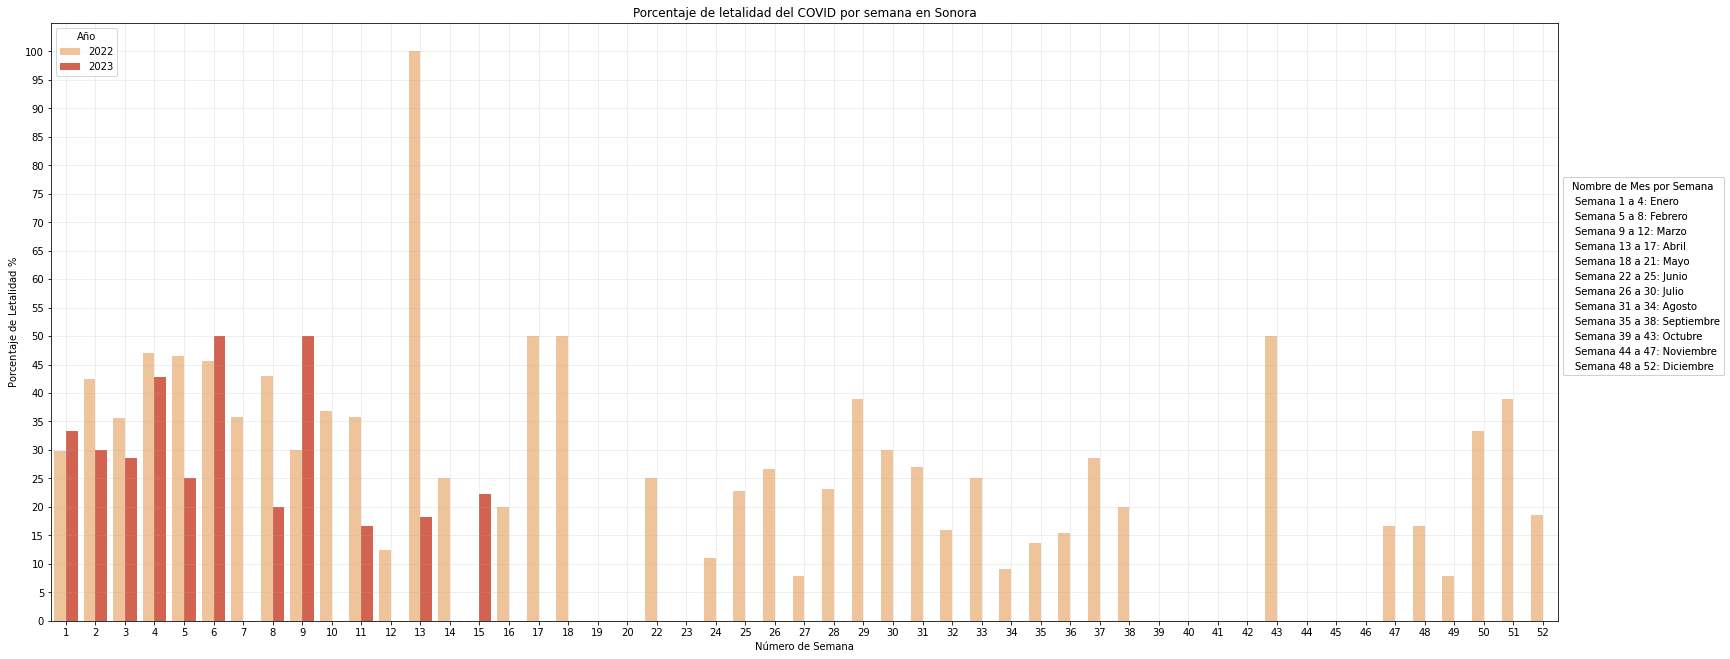

In [154]:
# Gráfico de prueba
plt.figure(figsize=(27,11))
ax = sns.barplot(x=df_sonora_semana['NO_SEMANA'], y=df_sonora_semana['LETALIDAD_SEM'], hue=df_sonora_semana['YEAR'], palette='OrRd')

plt.xlabel('Número de Semana')
plt.ylabel(r'Porcentaje de Letalidad $\%$')
plt.title('Porcentaje de letalidad del COVID por semana en Sonora')
#plt.legend(title='Año')
plt.yticks(range(0,101, 5))
plt.xticks(rotation=0)
plt.grid(alpha=0.25)

legend1 = ax.legend(title='Año')
ax.add_artist(legend1)

legend2 = ax.legend(labels_semana_mes, title='Nombre de Mes por Semana', loc='upper left', handlelength=0, bbox_to_anchor=(1,0.75))
ax.add_artist(legend2)

plt.show()

### Dataframe Hermosillo

In [41]:
# Identificador de sonora: 26. Hermosillo: 30
df_hermosillo_1 = df_mexico_1[(df_mexico_1['MUNICIPIO_RES'] == 30) & (df_mexico_1['ENTIDAD_RES'] == 26)]
df_hermosillo_1.shape

(1154, 42)

In [42]:
# Verficiar total personas en semana 1 de 2022
df_hermosillo_1[(df_hermosillo_1['NO_SEMANA'] == 1) & (df_hermosillo_1.index.year == 2022)]['NO_SEMANA'].count()

56

In [43]:
# Verificar personas muertas en la semana 1 de 2022
df_hermosillo_1[(df_hermosillo_1['MUERTE'] == 1) & (df_hermosillo_1['NO_SEMANA'] == 1) & (df_hermosillo_1.index.year == 2022)]['NO_SEMANA'].count()

9

In [44]:
# Verificar personas que sobrevivieron en la semana 1 de 2022
df_hermosillo_1[(df_hermosillo_1['MUERTE'] == 0) & (df_hermosillo_1['NO_SEMANA'] == 1) & (df_hermosillo_1.index.year == 2022)]['NO_SEMANA'].count()

47

In [45]:
# Contamos el total de personas y sumamos las que murieron (unos)
df_hermosillo_semana = df_hermosillo_1[['MUERTE', 'NO_SEMANA', 'YEAR']].groupby(['YEAR', 'NO_SEMANA']).agg(['sum', 'count']).reset_index()
df_hermosillo_semana.head(10)

YEAR NO_SEMANA MUERTE      
                     sum count
0  2022         1      9    56
1  2022         2     28    86
2  2022         3     40   140
3  2022         4     52   130
4  2022         5     47   122
5  2022         6     26    68
6  2022         7     17    50
7  2022         8     18    46
8  2022         9      6    22
9  2022        10      2     8

In [46]:
# 'Aplanar' nombres de columnas multi-index
df_hermosillo_semana.columns = ["_".join(pair) for pair in df_hermosillo_semana.columns]
df_hermosillo_semana.head(10)

,YEAR_,NO_SEMANA_,MUERTE_sum,MUERTE_count
0,2022,1,9,56
1,2022,2,28,86
2,2022,3,40,140
3,2022,4,52,130
4,2022,5,47,122
5,2022,6,26,68
6,2022,7,17,50
7,2022,8,18,46
8,2022,9,6,22
9,2022,10,2,8


In [47]:
# Calculamos letalidad en porcentaje
df_hermosillo_semana['LETALIDAD_SEM'] = (df_hermosillo_semana['MUERTE_sum'] / df_hermosillo_semana['MUERTE_count'])*100
df_hermosillo_semana.head(10)

,YEAR_,NO_SEMANA_,MUERTE_sum,MUERTE_count,LETALIDAD_SEM
0,2022,1,9,56,16.071429
1,2022,2,28,86,32.558140
2,2022,3,40,140,28.571429
3,2022,4,52,130,40.000000
4,2022,5,47,122,38.524590
5,2022,6,26,68,38.235294
6,2022,7,17,50,34.000000
7,2022,8,18,46,39.130435
8,2022,9,6,22,27.272727
9,2022,10,2,8,25.000000


In [48]:
df_hermosillo_semana.rename(
    columns={
        'YEAR_': 'YEAR',
        'NO_SEMANA_': 'NO_SEMANA',
        'MUERTE_sum': 'PERSONAS_MUERTAS',
        'MUERTE_count': 'TOTAL_INGRESADOS',
    },
    inplace=True
)
df_hermosillo_semana

,YEAR,NO_SEMANA,PERSONAS_MUERTAS,TOTAL_INGRESADOS,LETALIDAD_SEM
0,2022,1,9,56,16.071429
1,2022,2,28,86,32.558140
2,2022,3,40,140,28.571429
3,2022,4,52,130,40.000000
4,2022,5,47,122,38.524590
5,2022,6,26,68,38.235294
6,2022,7,17,50,34.000000
7,2022,8,18,46,39.130435
8,2022,9,6,22,27.272727
9,2022,10,2,8,25.000000


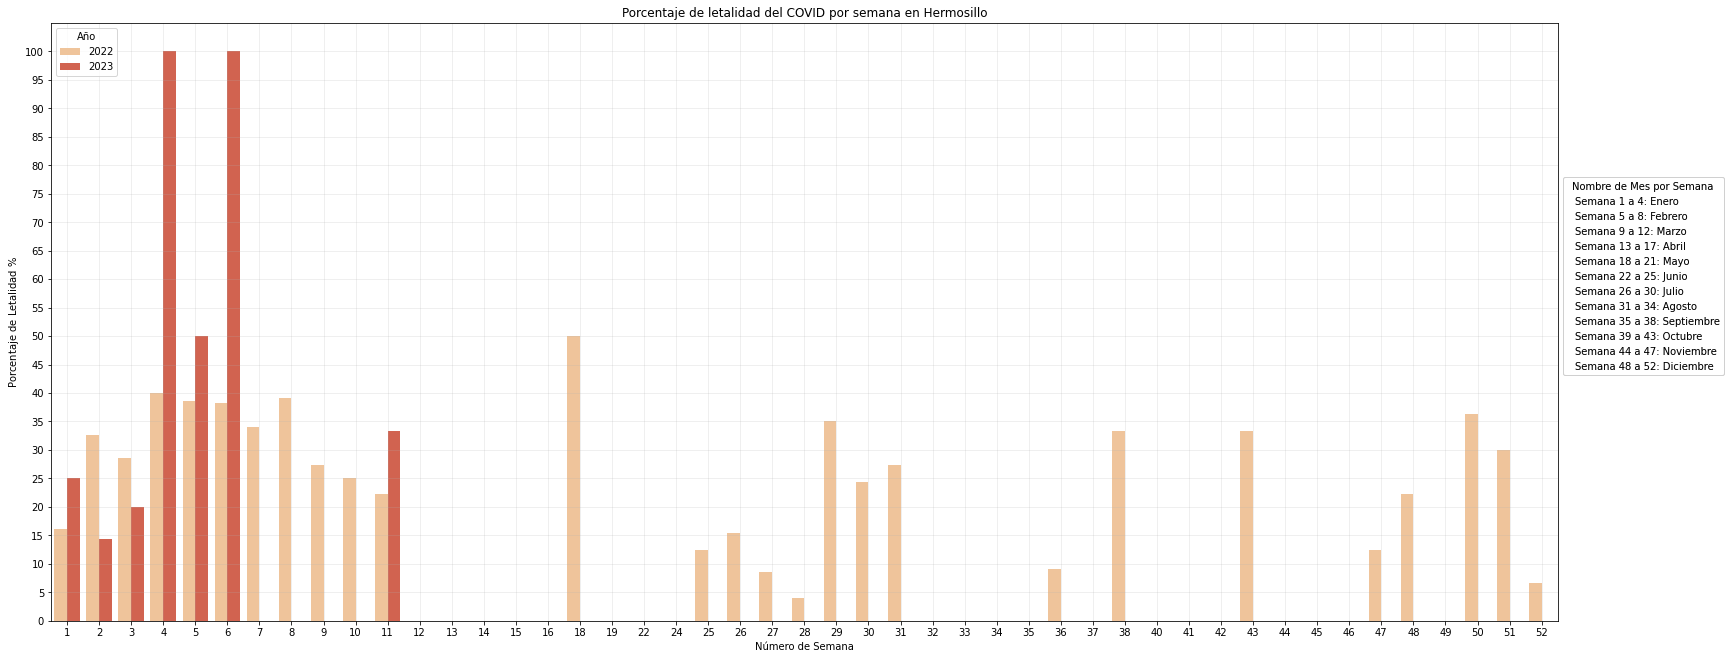

In [155]:
# Gráfica de prueba
plt.figure(figsize=(27,11))
ax = sns.barplot(x=df_hermosillo_semana['NO_SEMANA'], y=df_hermosillo_semana['LETALIDAD_SEM'], hue=df_hermosillo_semana['YEAR'], palette='OrRd')

plt.xlabel('Número de Semana')
plt.ylabel(r'Porcentaje de Letalidad $\%$')
plt.title('Porcentaje de letalidad del COVID por semana en Hermosillo')
#plt.legend(title='Año')
plt.yticks(range(0,101, 5))
plt.xticks(rotation=0)
plt.grid(alpha=0.25)

legend1 = ax.legend(title='Año')
ax.add_artist(legend1)

legend2 = ax.legend(labels_semana_mes, title='Nombre de Mes por Semana', loc='upper left', handlelength=0, bbox_to_anchor=(1,0.75))
ax.add_artist(legend2)

plt.show()

### Figura

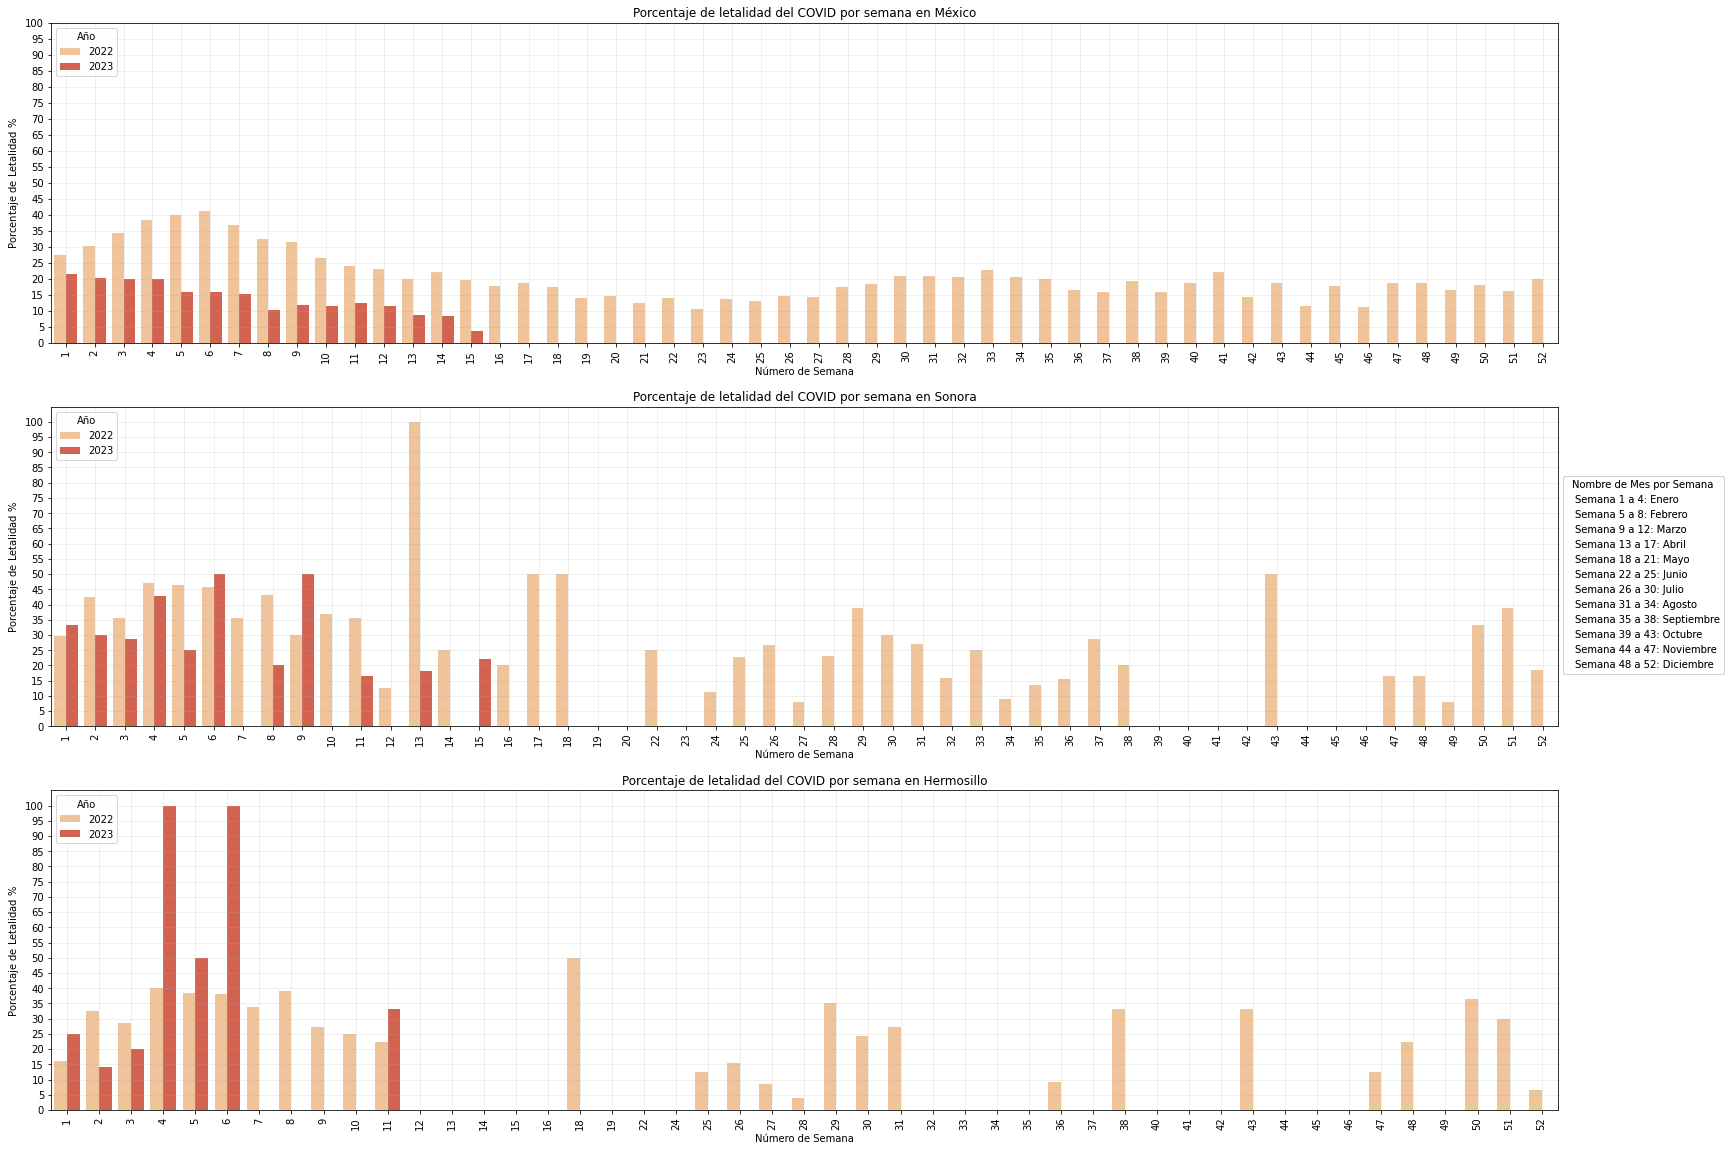

In [162]:
plt.figure(figsize=(27,20))
#fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(27,20))

plt.subplot(3,1,1)
ax1 = sns.barplot(x=df_mexico_semana['NO_SEMANA'], y=df_mexico_semana['LETALIDAD_SEM'], hue=df_mexico_semana['YEAR'], palette='OrRd')
plt.title('Porcentaje de letalidad del COVID por semana en México')
plt.xlabel('Número de Semana')
plt.ylabel(r'Porcentaje de Letalidad $\%$')
plt.yticks(range(0,101, 5))
plt.xticks(rotation=0)
plt.grid(alpha=0.25)

legend1 = ax1.legend(title='Año')
ax1.add_artist(legend1)
legend2 = ax1.legend(labels_semana_mes, title='Nombre de Mes por Semana', loc='upper left', handlelength=0, bbox_to_anchor=(1,-0.4))
ax1.add_artist(legend2)

plt.subplot(3,1,2)
ax2 = sns.barplot(x=df_sonora_semana['NO_SEMANA'], y=df_sonora_semana['LETALIDAD_SEM'], hue=df_sonora_semana['YEAR'], palette='OrRd')
plt.title('Porcentaje de letalidad del COVID por semana en Sonora')
plt.xlabel('Número de Semana')
plt.ylabel(r'Porcentaje de Letalidad $\%$')
plt.legend(title='Año')
plt.yticks(range(0,101, 5))
plt.xticks(rotation=0)
plt.grid(alpha=0.25)

plt.subplot(3,1,3)
ax3 = sns.barplot(x=df_hermosillo_semana['NO_SEMANA'], y=df_hermosillo_semana['LETALIDAD_SEM'], hue=df_hermosillo_semana['YEAR'], palette='OrRd')
plt.title('Porcentaje de letalidad del COVID por semana en Hermosillo')
plt.xlabel('Número de Semana')
plt.ylabel(r'Porcentaje de Letalidad $\%$')
plt.legend(title='Año')
plt.yticks(range(0,101, 5))
plt.xticks(rotation=0)
plt.grid(alpha=0.25)

plt.savefig('figura.png', facecolor='white', transparent=False) # Guardar plot

plt.show()

Cabe aclarar que algunas semanas no tiene barras ya que en esa semana no murieron personas (0% de letalidad en dicha semana)

### Nuevo Dataframe

In [51]:
df_nuevo_1 = df_hosp_covid.copy(deep=True)

In [52]:
df_nuevo_1.head(10)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,MUERTE,NO_SEMANA,YEAR
FECHA_INGRESO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-08-19,2023-04-18,100caf,1,6,17,1,21,17,1,2,2022-08-14,NaT,2,1,84,1,2,2,2,1,2,2,2,1,2,1,2,2,2,2,2,97,1,2,1,99,México,97,2,0,33,2022
2022-02-20,2023-04-18,0741e4,2,6,9,2,9,9,16,2,2022-02-13,2022-02-21,2,1,54,1,97,2,2,2,2,2,2,1,2,2,2,1,2,2,1,4,2,97,2,99,México,97,2,1,7,2022
2022-01-12,2023-04-18,1d5334,1,12,12,1,12,12,29,2,2022-01-09,NaT,2,2,28,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,97,1,1,3,99,México,97,2,0,2,2022
2022-01-06,2023-04-18,07977b,2,12,14,2,14,14,9,2,2022-01-02,NaT,2,2,30,1,97,2,2,2,2,2,2,2,2,2,2,2,2,1,2,97,1,1,3,99,México,97,2,0,1,2022
2022-01-25,2023-04-18,b26367,2,12,3,2,3,3,3,2,2022-01-24,NaT,2,2,69,1,97,2,2,2,1,2,2,1,2,1,2,2,1,99,2,97,1,1,3,99,México,97,2,0,4,2022
2022-01-08,2023-04-18,788695,2,11,25,1,25,25,1,2,2022-01-05,NaT,2,2,40,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,97,3,99,México,97,2,0,1,2022
2022-03-18,2023-04-18,79a031,2,12,9,1,9,9,15,2,2022-03-18,NaT,2,2,3,1,2,2,1,2,2,2,2,2,2,2,2,2,2,2,1,4,1,2,1,99,México,97,2,0,11,2022
2022-01-29,2023-04-18,8f1b25,1,12,12,1,12,12,55,2,2022-01-25,NaT,2,1,32,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,1,1,3,99,México,97,2,0,4,2022
2022-01-06,2023-04-18,da42fe,1,6,8,2,8,8,19,2,2022-01-02,2022-01-12,2,2,61,1,97,2,2,2,1,2,2,2,2,1,1,2,2,2,1,1,2,97,3,99,México,97,1,1,1,2022


In [53]:
# Con ayuda de la funcion cut de pandas podemos especificar los rangos (https://pandas.pydata.org/docs/reference/api/pandas.cut.html)
rangos = ['0 a 18', '18 a 30', '30 a 60', '>60']

# Bins: (0,18], (18,30], (30,60], (30,150]
bins = [0, 18, 30, 60, 150]

In [54]:
df_nuevo_1['RANGO_EDAD'] = pd.cut(df_nuevo_1['EDAD'], bins=bins, labels=rangos)
df_nuevo_1[['RANGO_EDAD', 'EDAD']][:10]

,RANGO_EDAD,EDAD
FECHA_INGRESO,,
2022-08-19,>60,84
2022-02-20,30 a 60,54
2022-01-12,18 a 30,28
2022-01-06,18 a 30,30
2022-01-25,>60,69
2022-01-08,30 a 60,40
2022-03-18,0 a 18,3
2022-01-29,30 a 60,32
2022-01-06,>60,61


In [55]:
# Columnas pertinentes
df_nuevo_2 = df_nuevo_1[['MUERTE', 'RANGO_EDAD', 'YEAR']]
df_nuevo_2.head()

,MUERTE,RANGO_EDAD,YEAR
FECHA_INGRESO,,,
2022-08-19,0,>60,2022
2022-02-20,1,30 a 60,2022
2022-01-12,0,18 a 30,2022
2022-01-06,0,18 a 30,2022
2022-01-25,0,>60,2022


In [56]:
# Agrupamos por año y rango de edad y sumamos para obtener numeros de muertos y contamos para obtener total ingresados
df_nuevo_2 = df_nuevo_2.groupby(['YEAR', 'RANGO_EDAD']).agg(['sum', 'count']).reset_index()
df_nuevo_2.head(25)

YEAR RANGO_EDAD MUERTE       
                      sum  count
0  2022     0 a 18    330   8476
1  2022    18 a 30    507   8227
2  2022    30 a 60   6112  28829
3  2022        >60  18928  44520
4  2023     0 a 18     37   1485
5  2023    18 a 30     31    845
6  2023    30 a 60    328   3064
7  2023        >60   1490   6633

In [57]:
# 'Aplanar' nombres de columnas multi-index
df_nuevo_2.columns = ["_".join(pair) for pair in df_nuevo_2.columns]
df_nuevo_2.head(10)

,YEAR_,RANGO_EDAD_,MUERTE_sum,MUERTE_count
0,2022,0 a 18,330,8476
1,2022,18 a 30,507,8227
2,2022,30 a 60,6112,28829
3,2022,>60,18928,44520
4,2023,0 a 18,37,1485
5,2023,18 a 30,31,845
6,2023,30 a 60,328,3064
7,2023,>60,1490,6633


In [58]:
df_nuevo_2.rename(
    columns={
        'YEAR_': 'YEAR',
        'RANGO_EDAD_': 'RANGO_EDAD',
        'MUERTE_sum': 'NUM_PERSONAS_MUERTAS',
        'MUERTE_count': 'TOTAL_INGRESADOS',
    },
    inplace=True
)
df_nuevo_2.head(25)

,YEAR,RANGO_EDAD,NUM_PERSONAS_MUERTAS,TOTAL_INGRESADOS
0,2022,0 a 18,330,8476
1,2022,18 a 30,507,8227
2,2022,30 a 60,6112,28829
3,2022,>60,18928,44520
4,2023,0 a 18,37,1485
5,2023,18 a 30,31,845
6,2023,30 a 60,328,3064
7,2023,>60,1490,6633


In [59]:
# Calculamos letalidad en porcentaje
df_nuevo_2['LETALIDAD_PORCEN'] = (df_nuevo_2['NUM_PERSONAS_MUERTAS'] / df_nuevo_2['TOTAL_INGRESADOS'])*100
df_nuevo_2.head(10)

,YEAR,RANGO_EDAD,NUM_PERSONAS_MUERTAS,TOTAL_INGRESADOS,LETALIDAD_PORCEN
0,2022,0 a 18,330,8476,3.893346
1,2022,18 a 30,507,8227,6.162635
2,2022,30 a 60,6112,28829,21.200874
3,2022,>60,18928,44520,42.515723
4,2023,0 a 18,37,1485,2.491582
5,2023,18 a 30,31,845,3.668639
6,2023,30 a 60,328,3064,10.704961
7,2023,>60,1490,6633,22.463440


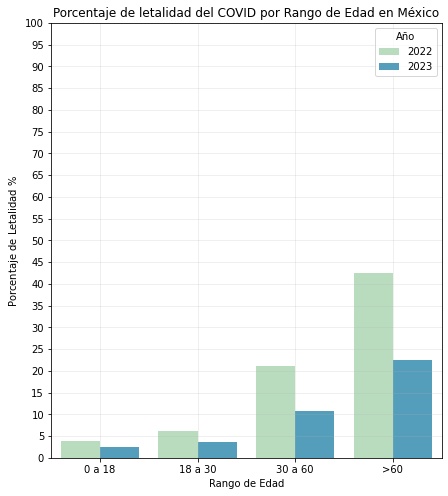

In [163]:
plt.figure(figsize=(7,8))
ax = sns.barplot(x=df_nuevo_2['RANGO_EDAD'], y=df_nuevo_2['LETALIDAD_PORCEN'], hue=df_nuevo_2['YEAR'], palette='GnBu') # Dark2

plt.xlabel('Rango de Edad')
plt.ylabel(r'Porcentaje de Letalidad $\%$')
plt.title('Porcentaje de letalidad del COVID por Rango de Edad en México')
plt.legend(title='Año')
plt.yticks(range(0,101, 5))
plt.xticks(rotation=0)
plt.grid(alpha=0.25)
plt.show()

La gráfica confirma lo que los expertos decían, los adultos mayores fueron (y siguen siendo) los más afectados por el COVID-19

In [61]:
# Guardar nuevo dataframe
df_nuevo_2.to_csv('tabla.csv.zip', compression='zip')